# Uber Data Challenge: Predicting Rider Retention

#### Load libraries and preferences

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix
from pandas_ml import ConfusionMatrix
from sklearn import ensemble

from datetime import datetime, timedelta
from matplotlib.pylab import rcParams
from __future__ import division
from fractions import Fraction

import warnings
import pylab
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np

%matplotlib inline
rcParams['figure.figsize'] = 15, 6
warnings.filterwarnings('ignore')
sns.set(style="white")

#### Upload json file: uber_data_challenge.json

In [2]:
# Had issues reading NaN from json file, swapped all NaN for 'null' in uber_data_challenge.json
driver_df = pd.read_json('uber_data_challenge.json')

#### Ensure dataframe is populated with json data

In [3]:
driver_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,uber_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


#### Print out the column feature titles

In [4]:
print driver_df.columns.values

[u'avg_dist' u'avg_rating_by_driver' u'avg_rating_of_driver' u'avg_surge'
 u'city' u'last_trip_date' u'phone' u'signup_date' u'surge_pct'
 u'trips_in_first_30_days' u'uber_black_user' u'weekday_pct']


## Data Properties: Exploration and Quality

There appears to be extreme values within the data set, e.g., max values for 'avg_dist', 'surge_pct', 'trips_in_first_30_days'. The summary statistics below considers numerical feature values.

In [5]:
summary = driver_df.describe()
summary = summary.transpose()
summary

,count,mean,std,min,25%,50%,75%,max
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,49799.0,4.778158,0.446652,1.0,4.70,5.00,5.00,5.00
avg_rating_of_driver,41878.0,4.601559,0.617338,1.0,4.30,4.90,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00


#### Overall count of phone types used by driver partners in dataset

iPhones are ~2.30209x more popular than Andriods. The popularity is exhibited throughout all 3 cities.

In [6]:
print driver_df['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64


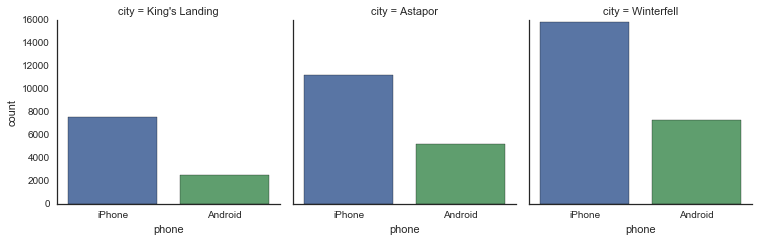

In [7]:
sns.factorplot("phone",col="city", data=driver_df, kind="count", size=3.5)

#### Overall representation of driver partner's participation in the 3 cities

Winterfell has the most driver partner participation (~1.4113x Astapor, ~2.30365x King's Landing) 

In [8]:
print driver_df['city'].value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64


#### Overall representation of users that took Uber Black in their first 30 days

Approximately 39% of driver partners took an Uber Black in their first 30 days. No city has more Uber Black drivers in their first 30 days than driver partners that did not use Uber Black.

In [9]:
print driver_df['uber_black_user'].value_counts()

False    31146
True     18854
Name: uber_black_user, dtype: int64


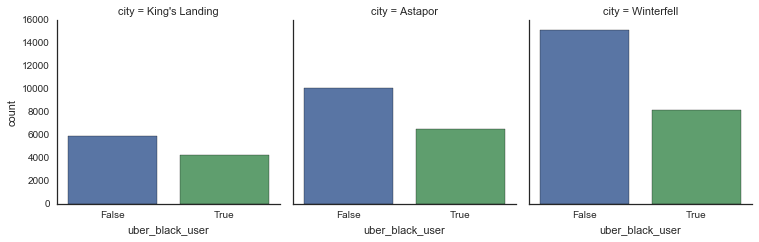

In [10]:
sns.factorplot("uber_black_user",col="city", data=driver_df, kind="count", size=3.5)

#### Which city has the highest percentage of trips completed in the first 30 days?

First, we augment a boolean feature column 'completed_first_trip_30' to the dataframe, 1 if the user has completed a trip within the first 30 days, 0 otherwise.

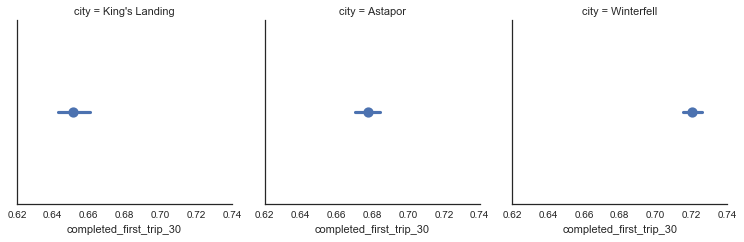

In [11]:
driver_df['completed_first_trip_30'] = \
    driver_df['trips_in_first_30_days'].map(lambda x: 1 if x is not 0 else int(x))
sns.factorplot("completed_first_trip_30",col="city", data=driver_df, kind="point", size=3.5)

Winterfell's users tend to have the highest percentage of 'trips_in_first_30_days' with approximately 72% completions, followed by Astapor with ~68% completions and lastly, King's Landing with ~65% completions. Remove column as keeping it in may increase collinearity if already present with the data.

In [12]:
driver_df = driver_df.drop('completed_first_trip_30',1)

<b><font size = "+1"> <font color="blue">What fraction of the observed users were retained, i.e., how many of them took trips from 2014-06-01 through 2014-07-01? </font></font></b>

First we'll convert the columns 'signup_date' and 'last_trip_date' from unicode to datetime objects.

In [13]:
driver_df['signup_date'] = pd.to_datetime(driver_df['signup_date'])
driver_df['last_trip_date'] = pd.to_datetime(driver_df['last_trip_date'])

Next, identify when the last trip date was within our user dataset.

In [14]:
max(driver_df['last_trip_date'])

Timestamp('2014-07-01 00:00:00')

I am working under the assumption that a report was pulled 2014-07-01 at the end of the day; therefore, to answer the question ... I want to find those users that took a trip in the previous 30 days from 2014-07-01, since a "pull" date is not provided in the question.

In [15]:
max(driver_df['last_trip_date']) - timedelta(days = 30)

Timestamp('2014-06-01 00:00:00')

I'll create a new boolean column, 'past_30_days_trip_active', which will signal if the user's last_trip_date was after 2014-06-01 (inclusive) then calculate the fraction of observed retained users.

In [16]:
driver_df['past_30_days_trip_active']  = [1 if x >= datetime(2014,6,1) else 0 for x in driver_df['last_trip_date']]
print str(sum(driver_df['past_30_days_trip_active'])/len(driver_df['past_30_days_trip_active']) * 100) \
+ "%" \
+ \
', or as a fraction', Fraction(sum(driver_df['past_30_days_trip_active'])/len(driver_df['past_30_days_trip_active']))

37.608%, or as a fraction 6774854991445985/18014398509481984


<font size = "+1"> <font color = "blue">The fraction of observed retained users is answered above. </font>

Remove column as keeping it in may increase collinearity if already present within the data.

In [17]:
driver_df = driver_df.drop('past_30_days_trip_active',1)

### Checking for missing values

In [18]:
columns = driver_df.columns.values
all_data_accounted_for = True;
for column in columns:
    if(sum(pd.isnull(driver_df[column])) != 0):
        print 'Warning: Missing \'' +  column +  '\' data.'
        all_data_accounted_for = False
if(all_data_accounted_for):
    print 'Success: Data Set is Complete.'

#### How many missing entries are there from 'avg_rating_by_driver'?

In [19]:
print str(sum(pd.isnull(driver_df['avg_rating_by_driver']) == True)) + " NaN entries from avg_rating_by_driver column."

201 NaN entries from avg_rating_by_driver column.


#### How many missing entries are there from 'avg_rating_of_driver'?

In [20]:
print str(sum(pd.isnull(driver_df['avg_rating_of_driver']) == True)) + " NaN entries from avg_rating_of_driver column."

8122 NaN entries from avg_rating_of_driver column.


#### How many missing entries are there from 'phone'?

In [21]:
print str(sum(pd.isnull(driver_df['phone']) == True)) + " missing entries from phone column."

396 missing entries from phone column.


#### Before we decide what to do about the missing values, lets see the distribution of the values and infer how much of the data is close to being outliers.  Let's see if there is an apparent skew in the distribution of the data using probability plots.

The feature columns 'avg_dist', 'surge_pct', 'trips_in_first_30_days', and 'avg_surge' appear to have a skew bearing a long tail to the right which signals an apparent trend of larger than expected values if the data were normally distributed.  The plot for 'surge_pct' is unusually interesting but interpretable since approximately 31% of the 'surge_pct' values are 0 (reasonable since riders may not want to take Uber if surge pricing is in effect at larger multipliers).

#### Approximately how much of the 'surge_pct' data is 0?

In [22]:
driver_df['bool_surge_pct'] = driver_df['surge_pct'].map(lambda x: 1 if x > 0.0 else 0)
print sum(driver_df['bool_surge_pct'])/len(driver_df['surge_pct'])

0.31182


In [23]:
driver_df = driver_df.drop('bool_surge_pct',1)

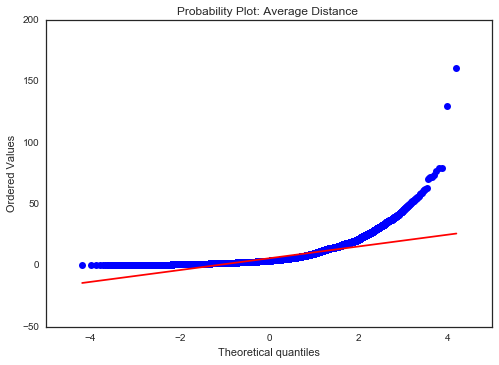

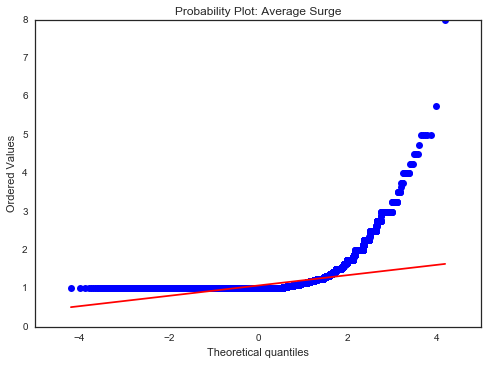

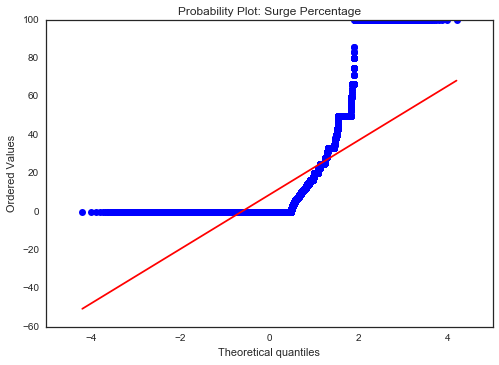

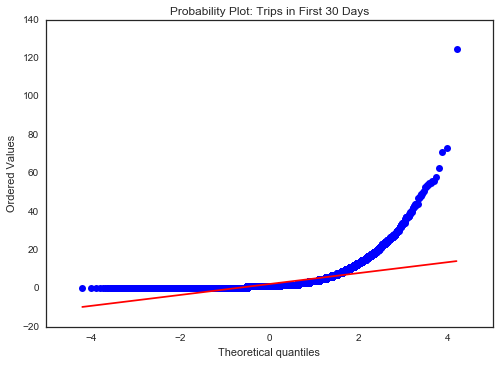

In [24]:
stats.probplot(driver_df['avg_dist'], dist="norm", plot=pylab)
pylab.title('Probability Plot: Average Distance ')
pylab.show()

stats.probplot(driver_df['avg_surge'], dist="norm", plot=pylab)
pylab.title('Probability Plot: Average Surge')
pylab.show()

stats.probplot(driver_df['surge_pct'], dist="norm", plot=pylab)
pylab.title('Probability Plot: Surge Percentage')
pylab.show()

stats.probplot(driver_df['trips_in_first_30_days'], dist="norm", plot=pylab)
pylab.title('Probability Plot: Trips in First 30 Days')
pylab.show()

Some overfitting will be expected since the model we select will learn on data which is heavily skewed in some of its features. 

###  Searching for collinearity among features

After calculating the correlation values between the features to determine the strength of the linear relationships, if they exist, there is a strong relationship between 'surge_pct' and 'avg_surge'. Better to visualize the correlation matrix over the features below to see other relationships, if they exist.

In [25]:
driver_df.corr()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,uber_black_user,weekday_pct
avg_dist,1.000000,0.080540,0.034509,-0.081491,-0.104414,-0.136329,0.032310,0.101652
avg_rating_by_driver,0.080540,1.000000,0.123175,0.010597,0.020103,-0.039115,0.009343,0.020442
avg_rating_of_driver,0.034509,0.123175,1.000000,-0.026189,-0.003899,-0.011302,-0.002086,0.014630
avg_surge,-0.081491,0.010597,-0.026189,1.000000,0.793582,-0.001841,-0.078791,-0.110071
surge_pct,-0.104414,0.020103,-0.003899,0.793582,1.000000,0.005720,-0.106861,-0.144918
trips_in_first_30_days,-0.136329,-0.039115,-0.011302,-0.001841,0.005720,1.000000,0.112210,0.050388
uber_black_user,0.032310,0.009343,-0.002086,-0.078791,-0.106861,0.112210,1.000000,0.035998
weekday_pct,0.101652,0.020442,0.014630,-0.110071,-0.144918,0.050388,0.035998,1.000000


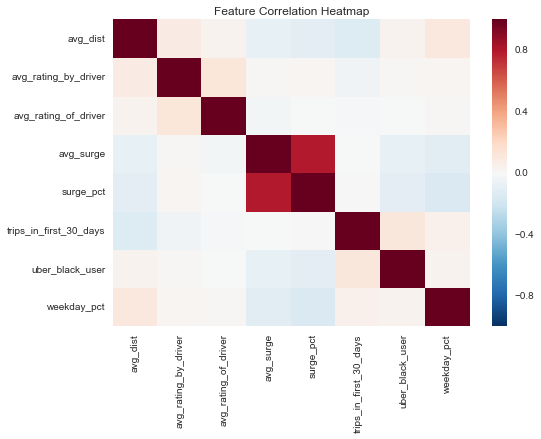

In [26]:
ax = plt.axes()
ax.set_title('Feature Correlation Heatmap')
sns.heatmap(driver_df.corr())

#### Correlation may not imply collinearity, so we we should determine if any of the features are linearly associated with another feature in our dataset outside of 'avg_surge' and 'surge_pct'.  At the very least, we can see if the relationship between the two features admit strong collinearity.  

If there is collinearity among the features, then the eigenvalues would be close to zero.

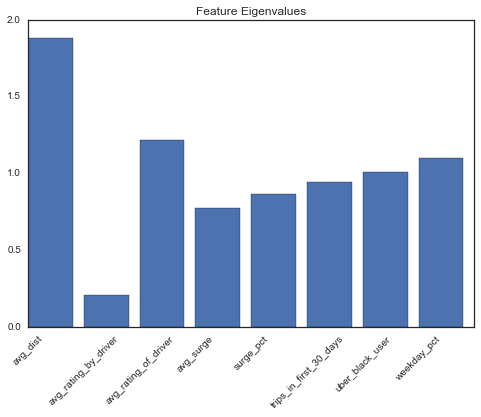

In [27]:
corr_labels = [
            'avg_dist', 
            'avg_rating_by_driver', 
            'avg_rating_of_driver', 
            'avg_surge', 
            'surge_pct', 
            'trips_in_first_30_days', 
            'uber_black_user', 
            'weekday_pct' 
            ]


corr = driver_df.corr();
eigen_values, eigen_vector = np.linalg.eig(corr) 

plt.bar(np.arange(len(eigen_values)), eigen_values)
plt.xticks(range(len(corr_labels)), corr_labels, rotation=45)
plt.title('Feature Eigenvalues')

The eigenvalues do not signal significant collinearity.  Although, the eigenvalue corresponding to 'average_rating_by_driver' (.2044688) is worth some investigation.  

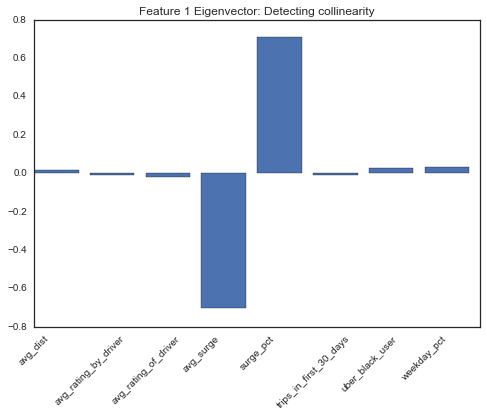

In [28]:
plt.bar(np.arange(len(eigen_vector)), eigen_vector[:,1])
plt.xticks(np.arange(len(eigen_vector)), corr_labels)
plt.xticks(rotation=45)
plt.title('Feature 1 Eigenvector: Detecting collinearity')

In eigen_vector[:,1], the larger absolute terms are -0.70142519,  0.71104734 which identify 'avg_surge', 'surge_pct' respectively admitting some collinearity among themselves.  We'll keep both 'avg_surge', 'surge_pct' features in the model since the collinearity strength is not quite on the border of troubling for decision tree algorithms (namely, gradient boosting which is invoked below).

## Data Preparation

### dummies

There are two categorical features in the dataset, 'city' and 'phone'.  Augmenting the dataset with dummy variables signaling these feature values.

In [29]:
dummies_city = pd.get_dummies(driver_df['city'])
dummies_phone = pd.get_dummies(driver_df['phone'])

driver_df = pd.concat([driver_df,dummies_city, dummies_phone], axis=1)
driver_df.drop(['city', 'phone'], axis=1, inplace=True)

In [30]:
driver_df.head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,uber_black_user,weekday_pct,Astapor,King's Landing,Winterfell,Android,iPhone
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,True,46.2,0,1,0,0,1
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,False,50.0,1,0,0,1,0
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,False,100.0,1,0,0,0,1
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,True,80.0,0,1,0,0,1
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,False,82.4,0,0,1,1,0
5,10.56,5.0,3.5,1.00,2014-06-06,2014-01-09,0.0,2,True,100.0,0,0,1,0,1
6,3.95,4.0,NaN,1.00,2014-01-25,2014-01-24,0.0,1,False,100.0,1,0,0,1,0
7,2.04,5.0,5.0,1.00,2014-01-29,2014-01-28,0.0,2,False,100.0,0,0,1,0,1
8,4.36,5.0,4.5,1.00,2014-02-01,2014-01-21,0.0,2,False,100.0,0,0,1,1,0
9,2.37,5.0,NaN,1.00,2014-01-05,2014-01-03,0.0,1,False,0.0,0,0,1,1,0


### filling in NaNs

'avg_rating_of_driver' feature has NaN values present in the dataframe, will replace with zeros as long as there are not naturally reported zeros.  Will also check feature 'avg_rating_by_driver' just in case.  Lastly, 'phone' still has missing values, no data imputation should occur where data is void for this feature.

In [31]:
driver_df[driver_df['avg_rating_of_driver'] == 0.0]

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,uber_black_user,weekday_pct,Astapor,King's Landing,Winterfell,Android,iPhone


In [32]:
driver_df[driver_df['avg_rating_by_driver'] == 0.0]

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,uber_black_user,weekday_pct,Astapor,King's Landing,Winterfell,Android,iPhone


In [33]:
driver_df['avg_rating_of_driver'].fillna(0.0, inplace=True)
driver_df['avg_rating_by_driver'].fillna(0.0, inplace=True)

In [34]:
driver_df.head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,uber_black_user,weekday_pct,Astapor,King's Landing,Winterfell,Android,iPhone
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,True,46.2,0,1,0,0,1
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,False,50.0,1,0,0,1,0
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,False,100.0,1,0,0,0,1
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,True,80.0,0,1,0,0,1
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,False,82.4,0,0,1,1,0
5,10.56,5.0,3.5,1.00,2014-06-06,2014-01-09,0.0,2,True,100.0,0,0,1,0,1
6,3.95,4.0,0.0,1.00,2014-01-25,2014-01-24,0.0,1,False,100.0,1,0,0,1,0
7,2.04,5.0,5.0,1.00,2014-01-29,2014-01-28,0.0,2,False,100.0,0,0,1,0,1
8,4.36,5.0,4.5,1.00,2014-02-01,2014-01-21,0.0,2,False,100.0,0,0,1,1,0
9,2.37,5.0,0.0,1.00,2014-01-05,2014-01-03,0.0,1,False,0.0,0,0,1,1,0


### Feature Engineering

To augment the dataset with information pertaining to the the proximity of the last trip date, I'll create a function which will map ordinal values to the months of the last trip date of each user. I do not include the raw 'last_trip_date' since it is a string and will not be appropriate for the gradient boosting classifer which is invoked below.  Moreover, transforming 'last_trip_date' using get_dummies will lead to a significant increase in feature columns that would not add value to the model. The idea is that drivers whom had their last trip more recently should have a higher likelihood of making a trip in the 6th month.  Therefore, the value mapping occurs as follows:
<ul>
  <li>1, if user's last trip was between January and February</li>
  <li>2, if user's last trip was between February and March</li>
  <li>3, if user's last trip was between March and April</li>
  <li>4, if user's last trip was between April and May</li>
  <li>5, if user's last trip was any time after May</li>
  <li>0, otherwise</li>
</ul>

In [35]:
def signal_last_trip_date(date):
    val = 0
    if datetime(2014,1,1) <= date < datetime(2014,2,1):
        val = 1
    elif datetime(2014,2,1) <= date < datetime(2014,3,1):
        val = 2
    elif datetime(2014,3,1) <= date < datetime(2014,4,1):
        val = 3        
    elif datetime(2014,4,1) <= date < datetime(2014,5,1):
        val = 4        
    elif datetime(2014,5,1) <= date:
        val = 5                
    return val

driver_df['last_trip_strength'] = driver_df['last_trip_date'].map(lambda x: signal_last_trip_date(x))

In [36]:
driver_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,uber_black_user,weekday_pct,Astapor,King's Landing,Winterfell,Android,iPhone,last_trip_strength
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,True,46.2,0,1,0,0,1,5
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,False,50.0,1,0,0,1,0,5
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,False,100.0,1,0,0,0,1,1
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,True,80.0,0,1,0,0,1,5
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,False,82.4,0,0,1,1,0,3


Transform the boolean representation of 'uber_black_user' from explicit True, False to 1, 0 in preparation for classifier.

In [37]:
driver_df['uber_black_user'] = driver_df['uber_black_user'].map(lambda x: 1 if x is True else 0)

In [38]:
driver_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,uber_black_user,weekday_pct,Astapor,King's Landing,Winterfell,Android,iPhone,last_trip_strength
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,1,46.2,0,1,0,0,1,5
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,0,50.0,1,0,0,1,0,5
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,0,100.0,1,0,0,0,1,1
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,1,80.0,0,1,0,0,1,5
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,0,82.4,0,0,1,1,0,3


### Ground Truth (target variable)

Since the goal is to build a predictive model to help Uber determine whether or not a user will be active in their 6th month on the system, we should establish 'ground-truth' and create a boolean column which identifies each user and if they were active in their 6th month.  If so, a value of 1 will be in the entry.  Otherwise, a 0 will reflect the user's inactivity in the 6th month. 

In [39]:
target  = [1 if x >= datetime(2014,6,1) else 0 for x in driver_df['last_trip_date']]

Remove the two datetime feature columns as they won't be necessary to the model as they are.

In [40]:
driver_df.drop(['signup_date', 'last_trip_date'], 1, inplace=True); 

## Invoking Gradient Boosting Classifier

Using train_test_split(), the function will automatically separate the entire set into training and testing sets as inputs to the gradient boosting classifier.

In [41]:
X = driver_df
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
gbc = GradientBoostingClassifier()
y_pred = gbc.fit(X_train, y_train).predict(X_test)

Since gbc has the feature importance property, we can show which features had the most impact in our model.

In [42]:
def graph_feature_importance(model, feature_names, autoscale=True, headroom=.09, width=10, summarized_columns=None):
    if autoscale:
        x_scale = model.feature_importances_.max()+2*headroom
    else:
        x_scale = 1
    
    feature_dict = dict(zip(feature_names, model.feature_importances_))
    if summarized_columns:
        for col_name in summarized_columns:
            sum_value = sum(x for i, x in feature_dict.iteritems() if col_name in i)
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i]
            for i in keys_to_remove:
                feature_dict.pop(i)
                
            feature_dict[col_name] = sum_value
            
    results = pd.Series(feature_dict.values(), index=feature_dict.keys())
    results.sort(axis=1)
    results.plot(kind="barh", figsize=(width, len(results)/4),xlim=(0,x_scale), fontsize=16)

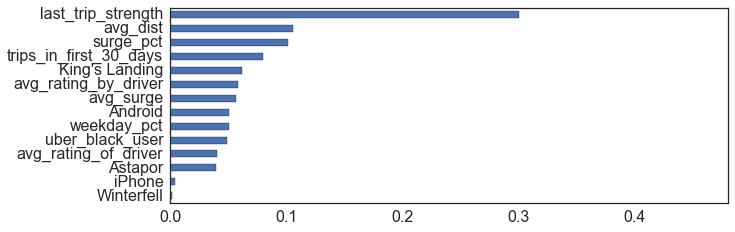

In [43]:
graph_feature_importance(gbc, driver_df.columns);

## Metrics and Validation

Accuracy:	0.8764
Precision:	0.790796525596
ROC_AUC:	0.947698324363


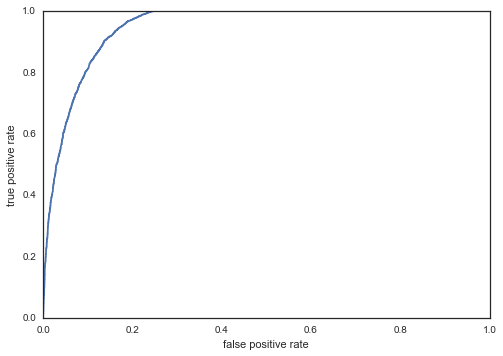

In [44]:
predictions = gbc.predict_proba(X_test)[:,1]
print "Accuracy:\t", accuracy_score(y_test, y_pred)

precisions, recalls, _ = precision_recall_curve(y_test, predictions)

print 'Precision:\t',precision_score(y_test, y_pred)

fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)

print 'ROC_AUC:\t', roc_auc

plt.plot(fpr, tpr)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

In [45]:
confusion_matrix = ConfusionMatrix(y_test, y_pred)
print confusion_matrix

Predicted     0     1  __all__
Actual                        
0          6676  1132     7808
1           413  4279     4692
__all__    7089  5411    12500


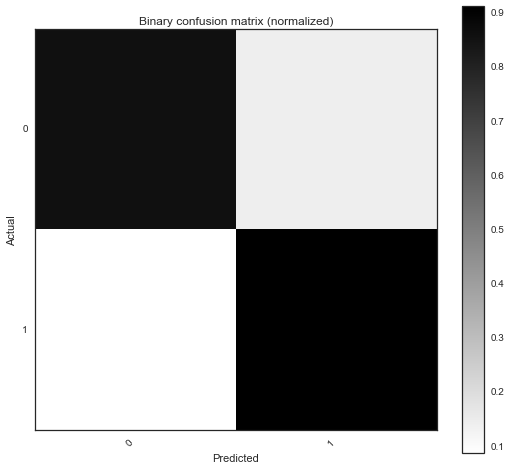

In [46]:
confusion_matrix.plot(normalized=True)

In [47]:
scores = cross_val_score(gbc, driver_df, target, cv=10, n_jobs=-1)
print scores
print 
print 'Cross Validation Accuracy: %.4f +/- %.4f' % (np.mean(scores), np.std(scores))

[ 0.8780244   0.87622476  0.87422515  0.86762647  0.8738      0.8726
  0.86957391  0.87717544  0.87017403  0.87617524]

Cross Validation Accuracy: 0.8736 +/- 0.0033


### Actionable Insights

Key index for partial dependency plots with respect to the top 5 feature importances.

In [48]:
# 13: last_trip_strength
# 0 : avg_dist
# 4 : surge_pct
# 5 : trips_in_first_30_days
# 9 : King's Landing

#### last_trip_strength

The feature we engineered within our dataset shows that those users had a last trip date from April forward would tend to also ride in the 6th month (June).  If the user's last trip date was before April, there is little indication that they would drive again in the 6th month.  <font color="blue">Uber should watch closely those users that have not drove in more than a month.  Find out why they stopped and incentivize them to get back on the road, to keep them on the road continuously.</font> 

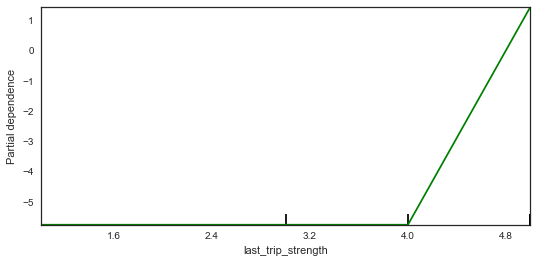

In [49]:
fig, axs = plot_partial_dependence( gbc, X_train, [13], feature_names=X_train.columns)
plt.show()

#### avg_dist

Distance does signal whether a user may drive in the 6th month although, the stength is not very strong.  The best interval of average distance appears to be from 3 to 6 miles, which may imply more "around-town" drivers are likely to continue driving in the 6th month.  <font color="blue">Uber may want to consider offering incentives to traditional long range drivers to minimize their avg_dist and keep their trips diverse and possibly more interesting.</font> 

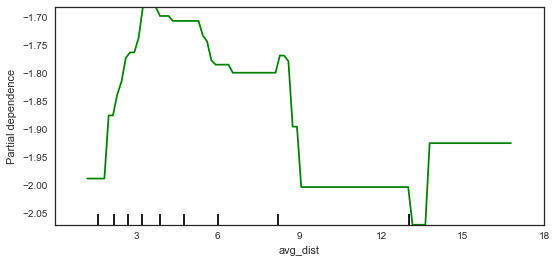

In [50]:
fig, axs = plot_partial_dependence( gbc, X_train, [0], feature_names=X_train.columns)
plt.show()

#### surge_pct

It's understood that the higher the surge_pct, the less likely users will get rides.  The spike around 5% may coincide with time of day (such as rush hour, late nights, etc.).  Unfortunately, this can not be validated with strictly the data.

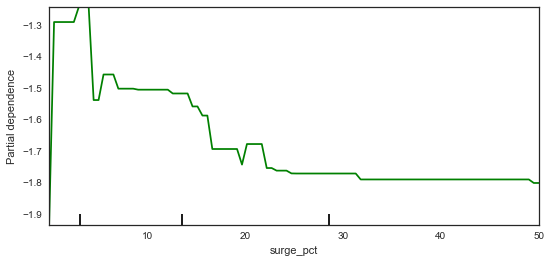

In [51]:
fig, axs = plot_partial_dependence( gbc, X_train, [4], feature_names=X_train.columns)
plt.show()

#### trips_in_first_30_days

Those users that take from approximately 10 to 30 rides in the first 30 days are a good indicator of continuing to ride.  <font color="blue">Uber should watch closely those users that took more than 30 trips within their first thrity days, perhaps "too much to soon" burnout is occuring?</font> 

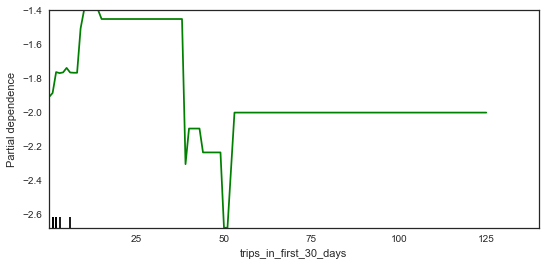

In [52]:
fig, axs = plot_partial_dependence( gbc, X_train, [5], feature_names=X_train.columns)
plt.show()

#### King's Landing

Users that signed up in King's Landing can be considered a signal to continue driver in the future over the two other cities in our dataset. <font color="blue">Uber should consider what constraints there are for drivers in other cities that are not applicable in King's Landing.</font> 

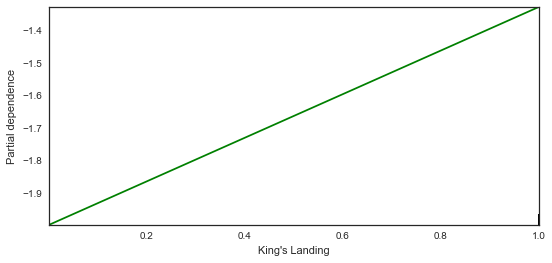

In [53]:
fig, axs = plot_partial_dependence( gbc, X_train, [9], feature_names=X_train.columns)
plt.show()